# Extended Trapping SINDy
By Alan Kaptanoglu

A very common issue is that models identified by system identification methods typically have no guarantees that the models are numerically or physically stable. This can be addressed with heuristic, data-driven, or analytic closure models, but we have recently directly promoted globally stable models into the system identification itself (see the Example 8 Jupyter notebook). This is really nice but there are three potential caveats, (1) the regression is nonconvex and there a number of hyperparameters, so this method can be difficult to learn, and (2) in order to promote global stability, one needs an analytic result from stability theory, and the one we use applies only for quadratically nonlinear dynamics (typically fluid and plasma flows) with energy-preserving, quadratic, nonlinearities. Moreover, we have now (3) additionally shown that generic quadratically nonlinear models will always be globally *unbounded*, so for these situations we can also promote local Lyapunov stability of the origin using some variations of the original Trapping SINDy algorithm. That is the goal of this notebook -- to illustrate how various forms of global and local stability can be promoted explicitly in the SINDy method to obtain stable data-driven models.

For the following, we will consider dynamical models of the form
$$\dot{x}_i = L_{ij}x_j + Q_{ijk}x_ix_jx_k.$$
For global stability promotion, we will require skew-symmetry in the quadratic coefficients
$$ Q_{ijk} + Q_{jik} + Q_{kij} = 0.$$
This equation will be implemented as a hard constraint in the optimization. However, for dynamical models that do not satisfy this condition, we can still promote locally stable models that are stable even at fairly large distances of the origin. The following examples show different ways to relax this hard constraint.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pysindy as ps 
from scipy.integrate import solve_ivp
import matplotlib.gridspec as gridspec
import scipy.io as sio

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Define some setup and plotting functions
# Build the skew-symmetric nonlinearity constraints
def make_constraints(r):
    q = 0
    N = int((r ** 2 + 3 * r) / 2.0)
    p = r + r * (r - 1) + int(r * (r - 1) * (r - 2) / 6.0)
    constraint_zeros = np.zeros(p)
    constraint_matrix = np.zeros((p, r * N))    
    
    # Set coefficients adorning terms like a_i^3 to zero
    for i in range(r):
        constraint_matrix[q, r * (N - r) + i * (r + 1)] = 1.0
        q = q + 1

    # Set coefficients adorning terms like a_ia_j^2 to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            constraint_matrix[q, r * (N - r + j) + i] = 1.0
            constraint_matrix[q, r * (r + j - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
            q = q + 1
    for i in range(r):
         for j in range(0, i):
            constraint_matrix[q, r * (N - r + j) + i] = 1.0
            constraint_matrix[q, r * (r + i - 1) + j + r * int(j * (2 * r - j - 3) / 2.0)] = 1.0
            q = q + 1

    # Set coefficients adorning terms like a_ia_ja_k to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            for k in range(j + 1, r):
                constraint_matrix[q, r * (r + k - 1) + i + r * int(j * (2 * r - j - 3) / 2.0)] = 1.0
                constraint_matrix[q, r * (r + k - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
                constraint_matrix[q, r * (r + j - 1) + k + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
                q = q + 1
                
    return constraint_zeros, constraint_matrix
    
    
# Use optimal m, and calculate eigenvalues(PW) to see if identified model is stable
def check_stability(r, Xi, mod_matrix, sindy_opt, mean_val):
    opt_m = sindy_opt.m_history_[-1]
    PL_tensor_unsym = sindy_opt.PL_unsym_
    PL_tensor = sindy_opt.PL_
    mPQ = -np.tensordot(
                sindy_opt.PQ_,
                opt_m, axes=([2], [0])
    ) - np.tensordot(
                np.transpose(sindy_opt.PQ_, [0, 2, 1, 3, 4]),
                opt_m, axes=([1], [0]),
    )
    mPQ = (mPQ + np.transpose(mPQ, [1, 0, 2, 3])) / 2.0
    P_tensor = PL_tensor - mPQ
    As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
    As = mod_matrix @ As
    eigvals, eigvecs = np.linalg.eigh(As)
    print('optimal m: ', opt_m)
    print('As eigvals: ', np.sort(eigvals))
    max_eigval = np.sort(eigvals)[-1]
    min_eigval = np.sort(eigvals)[0]
    L = np.tensordot(PL_tensor_unsym, Xi, axes=([3, 2], [0, 1]))
    Q = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
    d = np.dot(L, opt_m) + np.dot(np.tensordot(Q, opt_m, axes=([2], [0])), opt_m)
    d = mod_matrix @ d
    Rm = np.linalg.norm(d) / np.abs(max_eigval)
    Reff = Rm / mean_val
    print('Estimate of trapping region size, Rm = ', Rm)
    print('Normalized trapping region size, Reff = ', Reff)


# Plot first three modes in 3D for ground truth and SINDy prediction
def make_3d_plots(x_test, x_test_pred, filename):
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(8, 8))
    if filename == 'VonKarman':
        ind = -1
    else:
        ind = 2
    plt.plot(x_test[:, 0], x_test[:, 1], x_test[:, ind], 
             'r', label='true x')
    plt.plot(x_test_pred[:, 0], x_test_pred[:, 1], x_test_pred[:, ind], 
             'k', label='pred x')
    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_axis_off()
    plt.legend(fontsize=14)
    plt.show()


# Plot the SINDy fits of X and Xdot against the ground truth
def make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, filename):
    fig = plt.figure(figsize=(16, 8))
    spec = gridspec.GridSpec(ncols=2, nrows=r, figure=fig, hspace=0.0, wspace=0.0)
    for i in range(r):
        plt.subplot(spec[i, 0]) #r, 2, 2 * i + 2)
        plt.plot(t, xdot_test[:, i], 'r', 
                 label=r'true $\dot{x}_' + str(i) + '$')
        plt.plot(t, xdot_test_pred[:, i], 'k--', 
                 label=r'pred $\dot{x}_' + str(i) + '$')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.legend(fontsize=12)
        if i == r - 1:
            plt.xlabel('t', fontsize=18)
        plt.subplot(spec[i, 1])
        plt.plot(t, x_test[:, i], 'r', label=r'true $x_' + str(i) + '$')
        plt.plot(t, x_test_pred[:, i], 'k--', label=r'pred $x_' + str(i) + '$')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.legend(fontsize=12)
        if i == r - 1:
            plt.xlabel('t', fontsize=18)
        
    plt.show()
    
    
# Plot errors between m_{k+1} and m_k and similarly for the model coefficients
def make_progress_plots(r, sindy_opt):
    W = np.asarray(sindy_opt.history_)
    M = np.asarray(sindy_opt.m_history_)
    dW = np.zeros(W.shape[0])
    dM = np.zeros(M.shape[0])
    for i in range(1,W.shape[0]):
        dW[i] = np.sum((W[i, :, :] - W[i - 1, :, :]) ** 2)
        dM[i] = np.sum((M[i, :] - M[i - 1, :]) ** 2)
    plt.figure()
    plt.semilogy(dW, label=r'Coefficient progress, $\|\xi_{k+1} - \xi_k\|_2^2$')
    plt.semilogy(dM, label=r'Vector m progress, $\|m_{k+1} - m_k\|_2^2$')
    plt.xlabel('Algorithm iterations', fontsize=16)
    plt.ylabel('Errors', fontsize=16)
    plt.legend(fontsize=14)
    PWeigs = np.asarray(sindy_opt.PWeigs_history_)
    plt.figure()
    for j in range(r):
        if np.all(PWeigs[:, j] > 0.0):
            plt.semilogy(PWeigs[:, j], 
                         label=r'diag($P\xi)_{' + str(j) + str(j) + '}$')
        else:
            plt.plot(PWeigs[:, j], 
                     label=r'diag($P\xi)_{' + str(j) + str(j) + '}$')
        plt.xlabel('Algorithm iterations', fontsize=16)
        plt.legend(fontsize=12)
        plt.ylabel(r'Eigenvalues of $P\xi$', fontsize=16)


# Make a bar plot of the distribution of SINDy coefficients
# and distribution of Galerkin coefficients for the von Karman street
def make_bar(galerkin9, L, Q, Lens, Qens):
    bins = np.logspace(-11, 0, 50)
    plt.figure(figsize=(8, 4))
    plt.grid('True')
    galerkin_full = np.vstack((galerkin9['L'].reshape(r ** 2, 1), 
                               galerkin9['Q'].reshape(len(galerkin9['Q'].flatten()), 1)))
    plt.hist(np.abs(galerkin_full), bins=bins, label='POD-9 model')
    sindy_full = np.vstack((L.reshape(r ** 2, 1), 
                            Q.reshape(len(galerkin9['Q'].flatten()), 1)))
    plt.hist(np.abs(sindy_full.flatten()), bins=bins, color='k', 
             label='Trapping SINDy model (energy)')
    sindy_full = np.vstack((Lens.reshape(r ** 2, 1), 
                            Qens.reshape(len(galerkin9['Q'].flatten()), 1)))
    plt.hist(np.abs(sindy_full.flatten()), bins=bins, color='r', 
             label='Trapping SINDy model (enstrophy)')
    plt.xscale('log')
    plt.legend(fontsize=14)
    ax = plt.gca()
    ax.set_axisbelow(True)
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.set_yticks([0, 10, 20, 30])
    plt.xlabel('Coefficient values', fontsize=20)
    plt.ylabel('Number of coefficients', fontsize=20)
    plt.title('Histogram of coefficient values', fontsize=20)
    
    
# Helper function for reading and plotting the von Karman data
def get_velocity(file):
    global nel, nGLL
    field = nek.readnek(file)
    u = np.array([field.elem[i].vel[0, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])
    v = np.array([field.elem[i].vel[1, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])
    return u, v


# Helper function for reading and plotting the von Karman data
def get_vorticity(file):
    field = nek.readnek(file)
    vort = np.array([field.elem[i].temp[0, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])
    return vort


# Define von Karman grid
nx = 400
ny = 200
xmesh = np.linspace(-5, 15, nx)
ymesh = np.linspace(-5, 5, ny)
XX, YY = np.meshgrid(xmesh, ymesh)


# Helper function for plotting the von Karman data
def interp(field, method='cubic', 
           mask=(np.sqrt(XX ** 2 + YY ** 2) < 0.5).flatten('C')):
    global Cx, Cy, XX, YY
    """
    field - 1D array of cell values
    Cx, Cy - cell x-y values
    X, Y - meshgrid x-y values
    grid - if exists, should be an ngrid-dim logical that will be set to zer
    """
    ngrid = len(XX.flatten())
    grid_field = np.squeeze( np.reshape( griddata((Cx, Cy), field, (XX, YY), 
                                                  method=method), (ngrid, 1)) )
    if mask is not None:
        grid_field[mask] = 0
    return grid_field


# Helper function for plotting the von Karman data
def plot_field(field, clim=[-5, 5], label=None):
    """Plot cylinder field with masked circle"""
    im = plt.imshow(field, cmap='RdBu', vmin=clim[0], vmax=clim[1], 
                    origin='lower', extent=[-5, 15, -5, 5], 
                    interpolation='gaussian', label=label)
    cyl = plt.Circle((0, 0), 0.5, edgecolor='k', facecolor='gray')
    plt.gcf().gca().add_artist(cyl)
    return im


# Initialize quadratic SINDy library, with custom ordering 
# to be consistent with the constraint
library_functions = [lambda x:x, lambda x, y:x * y, lambda x:x ** 2]
library_function_names = [lambda x:x, lambda x, y:x + y, lambda x:x + x]
sindy_library = ps.CustomLibrary(library_functions=library_functions, 
                                 function_names=library_function_names)

# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-15
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-10

# Initialize a function for general quadratic Galerkin models
def galerkin_model(a, L, Q):
    """RHS of POD-Galerkin model, for time integration"""
    return (L @ a) + np.einsum('ijk,j,k->i', Q, a, a)

### Check global stability of the POD-Galerkin models
Okay, so we have loaded in some DNS data from the von Karman Street and generated (analytic) 5D POD-Galerkin models for this system (without and without the skew-symmetric constraint). The skew-symmetric models below are globally stable *if and only if* there exists a vector $\mathbf{m}$ such that following matrix is negative definite:
$$A^S_{ij} = L^S_{ij} + (Q_{ijk} + Q_{jik})m_k.$$
Note that if the quadratic terms are skew-symmetric this is equal to
$$A^S_{ij} = L^S_{ij} - Q_{kij}m_k.$$
A negative definite $\mathbf{A}^S$ turns out to also be necessary for the non-skew-symmetric models, but in this case is not sufficient for global boundedness.

A good algorithm for a nonlinear search for a good $\mathbf{m}$ is simulated annealing, and a simple interface is provided by scipy. We show below that the models that are exactly skew-symmetric are globally stable, and the models that (weakly) break this constraint are not. This is true whether or not we consider the energy, enstrophy, or some other positive definite function!

In [7]:
# Import simulated annealing algorithm from scipy
from scipy.optimize import dual_annealing as anneal_algo

# define the objective function to be minimized by simulated annealing
def obj_function(m, L_obj, Q_obj, P_obj):
    mQ_full = np.tensordot(Q_obj, m, axes=([2], [0])) + np.tensordot(np.transpose(
                            Q_obj, axes=[1, 2, 0]), m, axes=([1], [0])
                        )
    mQ_full = (mQ_full + mQ_full.T) / 2.0
    As = L_obj + P_obj @ mQ_full
    eigvals, eigvecs = np.linalg.eigh(As)
    return(eigvals[-1])

# Search between -5000, 5000 for each component of m
boundvals = np.zeros((r, 2))
boundmax = 5000
boundmin = -5000
boundvals[:, 0] = boundmin
boundvals[:, 1] = boundmax

# run simulated annealing for a non-skew-symmetric
# model in the enstrophy eigenbasis,
# display optimal m, and print 
# the corresponding objective function value
Ls_enstrophy = 0.5 * (L_enstrophy + L_enstrophy.T)
algo_sol = anneal_algo(obj_function, bounds=boundvals, 
                       args=(Ls_enstrophy, galerkin5['Q'], P_enstrophy), 
                       maxiter=200)
opt_m = algo_sol.x
opt_energy = algo_sol.fun
opt_result = algo_sol.message
print('Non-skew-symmetric enstrophy model result:')
print('Optimal m = ', opt_m)
print('Algorithm managed to reduce the largest eigenvalue of A^S to eig1 = ', 
      opt_energy, '\n')

# Repeat for the skew-symmetric model in the enstrophy eigenbasis
algo_sol = anneal_algo(obj_function, bounds=boundvals, 
                       args=(Ls_enstrophy, galerkin5['Q_ep'], P_enstrophy), 
                       maxiter=200)
opt_m = algo_sol.x
opt_energy = algo_sol.fun
opt_result = algo_sol.message
print('Skew-symmetric enstrophy model result:')
print('Optimal m = ', opt_m)
print('Algorithm managed to reduce the largest eigenvalue of A^S to eig1 = ', 
      opt_energy, '\n')

# Repeat using the energy
Ls = 0.5 * (galerkin5['L'] + galerkin5['L'].T)
algo_sol = anneal_algo(obj_function, bounds=boundvals, 
                       args=(Ls, galerkin5['Q'], P_energy), 
                       maxiter=200)
opt_m = algo_sol.x
opt_energy = algo_sol.fun
opt_result = algo_sol.message
print('Non-skew-symmetric energy model result:')
print('Optimal m = ', opt_m)
print('Algorithm managed to reduce the largest eigenvalue of A^S to eig1 = ', 
      opt_energy, '\n')

# Repeat with skew-symmetric quadratic terms
algo_sol = anneal_algo(obj_function, bounds=boundvals, 
                       args=(Ls, galerkin5['Q_ep'], P_energy), 
                       maxiter=200)
opt_m = algo_sol.x
opt_energy = algo_sol.fun
opt_result = algo_sol.message
print('Skew-symmetric energy model result:')
print('Optimal m = ', opt_m)
print('Algorithm managed to reduce the largest eigenvalue of A^S to eig1 = ', 
      opt_energy)

Non-skew-symmetric enstrophy model result:
Optimal m =  [3.56884690e-01 4.83895654e-01 1.91070764e+01 8.56732803e+01
 5.00000000e+03]
Algorithm managed to reduce the largest eigenvalue of A^S to eig1 =  -2.8595428003708885 

Skew-symmetric enstrophy model result:
Optimal m =  [3.64836310e-01 4.91184916e-01 2.12785209e+01 8.96041752e+01
 5.00000000e+03]
Algorithm managed to reduce the largest eigenvalue of A^S to eig1 =  -0.5291486167866061 

Non-skew-symmetric energy model result:
Optimal m =  [ 2.08286198e-01 -6.54584703e-02  5.29964032e+01  2.72959648e+01
  5.00000000e+03]
Algorithm managed to reduce the largest eigenvalue of A^S to eig1 =  -0.6759003102198253 

Skew-symmetric energy model result:
Optimal m =  [ 4.07887213e-02 -5.76954000e-03  1.53115272e+01  9.06739900e+00
  1.43744320e+03]
Algorithm managed to reduce the largest eigenvalue of A^S to eig1 =  -0.04388628059854641


### Promoting locally stable models with estimates of the stability radius
So far, we have promoted globally stable models with trapping SINDy by enforcing the skew-symmetry structure in the nonlinearities as a hard constraint in the optimization problem:
$$ argmin_{\mathbf{\xi},\mathbf m}\|\dot{\mathbf a} - \mathbf \Theta(\mathbf a) \mathbf{\xi}\|^2 + \gamma R(\mathbf \xi)  + \eta \lambda_1(\mathbf A)  \quad s.t. \quad Q_{ijk} + Q_{jik} + Q_{kji} = 0.$$
This problem is solved with a convex relaxation. Below, we relax the hard constraint slightly and instead solve 
$$ argmin_{\mathbf{\xi},\mathbf m}\|\dot{\mathbf a} - \mathbf \Theta(\mathbf a) \mathbf{\xi}\|^2 + \gamma R(\mathbf \xi)  + \eta \lambda_1(\mathbf A)  \quad s.t. \quad -\epsilon_Q \leq Q_{ijk} + Q_{jik} + Q_{kji} \leq \epsilon_Q.$$ 
This allows us to build locally Lyapunov stable models, and adjust the size of the local stability radius by varying $\epsilon_Q$. A conservative estimate of the local stability is:
$$\rho = \frac{\lambda_1(\mathbf A^S)}{2\epsilon_Q}.$$

In [58]:
max_iter = 30
eta = 1.0
threshold = 0.1
alpha_m = 5e-1 * eta
eps_Q = 1e-5

# Initial guess from previous run
m0 = [-0.04909302, -0.11772324, -0.01306215, -0.53335716, 3.3193437]

# Setup the inequality constraints
constraint_zeros, constraint_matrix = make_constraints(r)
constraint_zeros_extended = np.ones(len(constraint_zeros) * 2) * eps_Q
constraint_zeros_extended[len(constraint_zeros):] = eps_Q
constraint_matrix_extended = np.zeros((len(constraint_zeros) * 2, constraint_matrix.shape[-1]))
constraint_matrix_extended[:len(constraint_zeros), :] = constraint_matrix
constraint_matrix_extended[len(constraint_zeros):, :] = -constraint_matrix

# run trapping SINDy
sindy_opt = ps.TrappingSR3(
    threshold=threshold, eta=eta,
    alpha_m=alpha_m,
    max_iter=max_iter,
    m0=m0,
    constraint_lhs=constraint_matrix_extended,
    constraint_rhs=constraint_zeros_extended,
    constraint_order="feature",
    verbose=True,
    inequality_constraints=True,
    eps_solver=1e-9
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(a, t=t)
Xi = model.coefficients().T
PL_tensor = sindy_opt.PL_
PQ_tensor = sindy_opt.PQ_
Lenergy = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Qenergy = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
mean_val = np.mean(a, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_stability(r, Xi, np.eye(r), sindy_opt, mean_val)

 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 2.045e+00 ... 2.510e-03 ... 9.80e-01 ... -4.00e-25 ... -1.20e-24 ... 3.03e+00
    1 ... 2.106e+00 ... 3.781e-03 ... 1.02e+00 ... -4.50e-25 ... -1.35e-24 ... 3.13e+00
    2 ... 2.118e+00 ... 3.686e-03 ... 1.03e+00 ... -4.50e-25 ... -1.35e-24 ... 3.15e+00
    3 ... 2.120e+00 ... 3.698e-03 ... 1.03e+00 ... -4.50e-25 ... -1.35e-24 ... 3.15e+00
    4 ... 2.120e+00 ... 3.680e-03 ... 1.03e+00 ... -4.50e-25 ... -1.35e-24 ... 3.15e+00
    5 ... 2.121e+00 ... 3.668e-03 ... 1.03e+00 ... -4.50e-25 ... -1.35e-24 ... 3.15e+00
    6 ... 2.122e+00 ... 3.654e-03 ... 1.03e+00 ... -4.50e-25 ... -1.35e-24 ... 3.15e+00
    7 ... 2.122e+00 ... 3.641e-03 ... 1.03e+00 ... -4.50e-25 ... -1.35e-24 ... 3.15e+00
    8 ... 2.123e+00 ... 3.628e-03 ... 1.03e+00 ... -4.50e-25 ... -1.35e-24 ... 3.15e+00
    9 ... 2.124e+00 ... 3.615e-03 ... 1.03e+00 ... -4.50e-25 ... -1.35e-24 ... 3.16e+00
   10 ... 2.124e+00 ... 3.602e-

/Users/user01/pysindy/pysindy/optimizers/trapping_sr3.py:824: ConvergenceWarning: TrappingSR3._reduce did not converge after 30 iters.
  warnings.warn(


### Check inequality constraints are working!
Note that this may fail if the CVXPY solver error tolerance is too low. In that case, increase the value of eps_solver.

In [59]:
Q = np.tensordot(sindy_opt.PQ_, Xi, axes=([4, 3], [0, 1]))
print(np.max(abs(Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1]))))

3.0000000000024344e-05


Looks like the inequality constraints are working well. Above, the maximum value is actually $Q_{ijk}^{max} = 3\epsilon_Q$, but this extra factor is just an artifact of the way the constraints work in make_constraints.

### Plot how the local stability radius changes as the algorithm iterates
As the algorithm iterates, it is biasing the model to have a negative definite $\mathbf{A}^S$ matrix. Once this is true, we can estimate the local Lyapunov stability radius $\rho$, and see that as the algorithm promotes larger $-\lambda_1$ (the max eigenvalue of $\mathbf{A}^S$), the stability radius increases. 

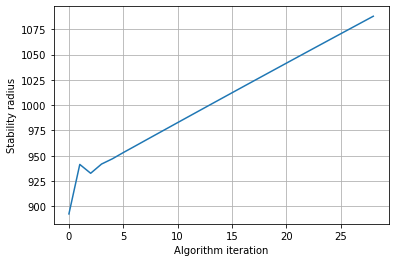

In [62]:
eigs = sindy_opt.PWeigs_history_
rhos = []
for i in range(len(eigs)):
    if eigs[i][-1] < 0:
        rhos.append(-eigs[i][-1] / (2 * eps_Q))
plt.plot(rhos[1:])
plt.grid(True)
plt.ylabel('Stability radius')
plt.xlabel('Algorithm iteration')
plt.show()

### Check for unbounded trajectories
So we have used inequality constraints to promote locally Lyapunov stable models, and obtained an estimate of the stability radius. Let's verify that trajectories within this radius are bounded, but trajectories outside this radius can be unstable.

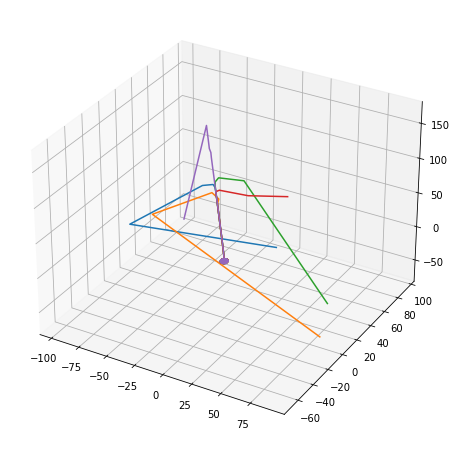

In [71]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(8, 8))
t_sim = np.linspace(0, len(t), len(t) * 3)
for i in range(3):
    a0 = (np.random.rand(r) - 0.5) * 200  #* rhos[-1]
    x_traj = model.simulate(a0, t_sim)
    plt.plot(x_traj[:, 0], x_traj[:, 1], x_traj[:, -1])

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


KeyboardInterrupt: 

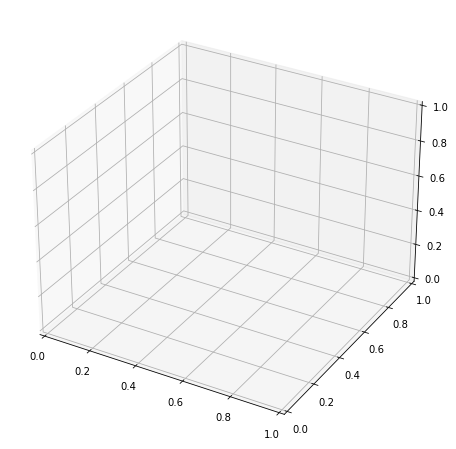

In [72]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(8, 8))
t_sim = np.linspace(0, len(t), len(t) * 3)
for i in range(3):
    a0 = (np.random.rand(r) - 0.5) * 2000  #* rhos[-1]
    x_traj = model.simulate(a0, t_sim)
    plt.plot(x_traj[:, 0], x_traj[:, 1], x_traj[:, -1])

In [172]:
max_iter = 300
eta = 1.0e3
threshold = 0.1
alpha_m = 5e-2 * eta
eps_Q = 0.05

# Initial guess from previous run
# m0 = [-0.04909302, -0.11772324, -0.01306215, -0.53335716, 3.3193437]

# Setup the inequality constraints
constraint_zeros, constraint_matrix = make_constraints(r)
constraint_zeros_extended = np.ones(len(constraint_zeros) * 2) * eps_Q
constraint_zeros_extended[len(constraint_zeros):] = eps_Q
constraint_matrix_extended = np.zeros((len(constraint_zeros) * 2, constraint_matrix.shape[-1]))
constraint_matrix_extended[:len(constraint_zeros), :] = constraint_matrix
constraint_matrix_extended[len(constraint_zeros):, :] = -constraint_matrix

# run trapping SINDy
sindy_opt = ps.TrappingSR3(
    threshold=threshold, eta=eta,
    alpha_m=alpha_m,
    max_iter=max_iter,
    # m0=m0,
    constraint_lhs=constraint_matrix_extended,
    constraint_rhs=constraint_zeros_extended,
    constraint_order="feature",
    verbose=True,
    inequality_constraints=True,
    eps_solver=1e-5
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(a, t=t)
Xi = model.coefficients().T
PL_tensor = sindy_opt.PL_
PQ_tensor = sindy_opt.PQ_
Lenergy = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Qenergy = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
mean_val = np.mean(a, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_stability(r, Xi, np.eye(r), sindy_opt, mean_val)

 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 3.882e-01 ... 2.901e-04 ... 7.14e-01 ... -1.02e-21 ... -3.07e-21 ... 1.10e+00
    1 ... 3.882e-01 ... 2.895e-04 ... 7.14e-01 ... -1.02e-21 ... -3.07e-21 ... 1.10e+00
    2 ... 3.882e-01 ... 2.893e-04 ... 7.14e-01 ... -1.02e-21 ... -3.07e-21 ... 1.10e+00
    3 ... 3.882e-01 ... 2.890e-04 ... 7.14e-01 ... -1.02e-21 ... -3.07e-21 ... 1.10e+00
    4 ... 3.882e-01 ... 2.887e-04 ... 7.14e-01 ... -1.02e-21 ... -3.07e-21 ... 1.10e+00
    5 ... 3.882e-01 ... 2.884e-04 ... 7.14e-01 ... -1.02e-21 ... -3.07e-21 ... 1.10e+00
    6 ... 3.882e-01 ... 2.881e-04 ... 7.14e-01 ... -1.02e-21 ... -3.07e-21 ... 1.10e+00
    7 ... 3.881e-01 ... 2.878e-04 ... 7.14e-01 ... -1.02e-21 ... -3.07e-21 ... 1.10e+00
    8 ... 3.881e-01 ... 2.875e-04 ... 7.14e-01 ... -1.02e-21 ... -3.07e-21 ... 1.10e+00
    9 ... 3.881e-01 ... 2.872e-04 ... 7.14e-01 ... -1.02e-21 ... -3.07e-21 ... 1.10e+00
   10 ... 3.881e-01 ... 2.869e-

   93 ... 3.880e-01 ... 2.653e-04 ... 7.14e-01 ... -1.02e-21 ... -3.07e-21 ... 1.10e+00
   94 ... 3.880e-01 ... 2.650e-04 ... 7.14e-01 ... -1.02e-21 ... -3.07e-21 ... 1.10e+00
   95 ... 3.880e-01 ... 2.648e-04 ... 7.14e-01 ... -1.02e-21 ... -3.07e-21 ... 1.10e+00
   96 ... 3.880e-01 ... 2.646e-04 ... 7.14e-01 ... -1.02e-21 ... -3.07e-21 ... 1.10e+00
   97 ... 3.880e-01 ... 2.643e-04 ... 7.14e-01 ... -1.02e-21 ... -3.07e-21 ... 1.10e+00
   98 ... 3.880e-01 ... 2.641e-04 ... 7.14e-01 ... -1.02e-21 ... -3.07e-21 ... 1.10e+00
   99 ... 3.880e-01 ... 2.639e-04 ... 7.14e-01 ... -1.02e-21 ... -3.07e-21 ... 1.10e+00
  100 ... 3.879e-01 ... 2.636e-04 ... 7.14e-01 ... -1.02e-21 ... -3.07e-21 ... 1.10e+00
  101 ... 3.879e-01 ... 2.634e-04 ... 7.14e-01 ... -1.02e-21 ... -3.07e-21 ... 1.10e+00
  102 ... 3.879e-01 ... 2.632e-04 ... 7.14e-01 ... -1.02e-21 ... -3.07e-21 ... 1.10e+00
  103 ... 3.879e-01 ... 2.629e-04 ... 7.14e-01 ... -1.02e-21 ... -3.07e-21 ... 1.10e+00
  104 ... 3.879e-01 ... 2.627e-0

  187 ... 3.878e-01 ... 2.456e-04 ... 7.15e-01 ... -1.02e-21 ... -3.07e-21 ... 1.10e+00
  188 ... 3.878e-01 ... 2.454e-04 ... 7.15e-01 ... -1.02e-21 ... -3.07e-21 ... 1.10e+00
  189 ... 3.878e-01 ... 2.452e-04 ... 7.15e-01 ... -1.02e-21 ... -3.07e-21 ... 1.10e+00
  190 ... 3.878e-01 ... 2.451e-04 ... 7.15e-01 ... -1.02e-21 ... -3.07e-21 ... 1.10e+00
  191 ... 3.878e-01 ... 2.449e-04 ... 7.15e-01 ... -1.02e-21 ... -3.07e-21 ... 1.10e+00
  192 ... 3.878e-01 ... 2.447e-04 ... 7.15e-01 ... -1.02e-21 ... -3.07e-21 ... 1.10e+00
  193 ... 3.878e-01 ... 2.445e-04 ... 7.15e-01 ... -1.02e-21 ... -3.07e-21 ... 1.10e+00
  194 ... 3.878e-01 ... 2.443e-04 ... 7.15e-01 ... -1.02e-21 ... -3.07e-21 ... 1.10e+00
  195 ... 3.878e-01 ... 2.441e-04 ... 7.15e-01 ... -1.02e-21 ... -3.07e-21 ... 1.10e+00
  196 ... 3.877e-01 ... 2.440e-04 ... 7.15e-01 ... -1.02e-21 ... -3.07e-21 ... 1.10e+00
  197 ... 3.877e-01 ... 2.438e-04 ... 7.15e-01 ... -1.02e-21 ... -3.07e-21 ... 1.10e+00
  198 ... 3.877e-01 ... 2.436e-0

  281 ... 3.876e-01 ... 2.299e-04 ... 7.15e-01 ... -1.02e-21 ... -3.06e-21 ... 1.10e+00
  282 ... 3.876e-01 ... 2.297e-04 ... 7.15e-01 ... -1.02e-21 ... -3.06e-21 ... 1.10e+00
  283 ... 3.876e-01 ... 2.296e-04 ... 7.15e-01 ... -1.02e-21 ... -3.06e-21 ... 1.10e+00
  284 ... 3.876e-01 ... 2.294e-04 ... 7.15e-01 ... -1.02e-21 ... -3.06e-21 ... 1.10e+00
  285 ... 3.876e-01 ... 2.293e-04 ... 7.15e-01 ... -1.02e-21 ... -3.06e-21 ... 1.10e+00
  286 ... 3.876e-01 ... 2.291e-04 ... 7.15e-01 ... -1.02e-21 ... -3.06e-21 ... 1.10e+00
  287 ... 3.876e-01 ... 2.290e-04 ... 7.15e-01 ... -1.02e-21 ... -3.06e-21 ... 1.10e+00
  288 ... 3.876e-01 ... 2.288e-04 ... 7.15e-01 ... -1.02e-21 ... -3.06e-21 ... 1.10e+00
  289 ... 3.876e-01 ... 2.287e-04 ... 7.15e-01 ... -1.02e-21 ... -3.06e-21 ... 1.10e+00
  290 ... 3.876e-01 ... 2.285e-04 ... 7.15e-01 ... -1.02e-21 ... -3.06e-21 ... 1.10e+00
  291 ... 3.876e-01 ... 2.284e-04 ... 7.15e-01 ... -1.02e-21 ... -3.06e-21 ... 1.10e+00
  292 ... 3.875e-01 ... 2.283e-0

/Users/user01/pysindy/pysindy/optimizers/trapping_sr3.py:824: ConvergenceWarning: TrappingSR3._reduce did not converge after 300 iters.
  warnings.warn(


0.15000015312018813


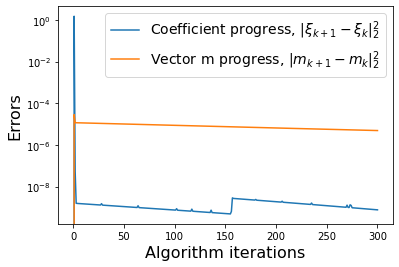

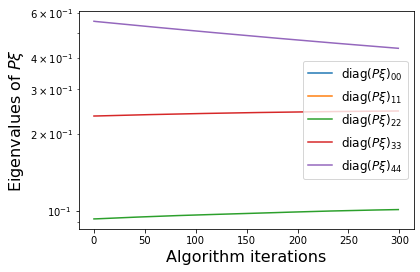

In [173]:
Q = np.tensordot(sindy_opt.PQ_, Xi, axes=([4, 3], [0, 1]))
print(np.max(abs(Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1]))))
make_progress_plots(r, sindy_opt)

We have relaxed the hard constraint slightly and solved the trapping SINDy objective function with inequality constraints dictating the amount of deviation allowed from perfect skew-symmetry in the quadratic coefficients:
$$ argmin_{\mathbf{\xi},\mathbf m}\|\dot{\mathbf a} - \mathbf \Theta(\mathbf a) \mathbf{\xi}\|^2 + \gamma R(\mathbf \xi)  + \eta \lambda_1(\mathbf A)  \quad s.t. \quad -\epsilon_Q \leq Q_{ijk} + Q_{jik} + Q_{kji} \leq \epsilon_Q.$$ 
This allowed us to build locally Lyapunov stable models, and adjust the size of the local stability radius by varying $\epsilon_Q$. However, two other loss terms that can be used as alternatives to increase the size of the stability radius while avoiding extra constraints:
$$\alpha\|Q_{ijk}\|$$
and
$$\beta\|Q_{ijk} + Q_{jki} + Q_{kij}\|.$$
We can combine all of these options into the following unconstrained optimization problem:
$$argmin_{\mathbf{\xi},\mathbf m}\|\dot{\mathbf a} - \mathbf \Theta(\mathbf a) \mathbf{\xi}\|^2 + \gamma R(\mathbf \xi)  + \eta \lambda_1(\mathbf A) + \alpha\|Q_{ijk}\| + \beta\|Q_{ijk} + Q_{jki} + Q_{kij}\|.$$
We now solve this problem for $\alpha \gg \beta$, $\alpha \ll \beta$, and $\alpha \sim \beta \sim 1.$

In [140]:
max_iter = 10000
eta = 1.0e20
alpha = 1.0e20
beta = 1e20
threshold = 0
alpha_m = 1e-3 * eta

# Initial guess from previous run
#m0 = [-0.04909302, -0.11772324, -0.01306215, -0.53335716, 3.3193437]

# run trapping SINDy... no more constraints!
sindy_opt = ps.TrappingSR3(
    threshold=threshold, eta=eta,
    alpha_m=alpha_m,
    beta=beta,
    max_iter=max_iter,
    #m0=m0,
    verbose=True,
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(a, t=t)
Xi = model.coefficients().T
PL_tensor = sindy_opt.PL_
PQ_tensor = sindy_opt.PQ_
Lenergy = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Qenergy = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
mean_val = np.mean(a, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_stability(r, Xi, np.eye(r), sindy_opt, mean_val)

 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 4.371e-02 ... 4.623e-06 ... 0.00e+00 ... -9.78e-21 ... -2.93e-20 ... 4.37e-02
 1000 ... 4.371e-02 ... 1.499e-05 ... 0.00e+00 ... -9.77e-21 ... -2.93e-20 ... 4.37e-02
 2000 ... 4.371e-02 ... 7.005e-05 ... 0.00e+00 ... -9.77e-21 ... -2.93e-20 ... 4.38e-02
 3000 ... 4.371e-02 ... 3.571e-04 ... 0.00e+00 ... -9.82e-21 ... -2.95e-20 ... 4.41e-02
 4000 ... 4.373e-02 ... 1.875e-03 ... 0.00e+00 ... -1.01e-20 ... -3.03e-20 ... 4.56e-02
 5000 ... 4.403e-02 ... 1.142e-02 ... 0.00e+00 ... -1.04e-20 ... -3.11e-20 ... 5.54e-02
 6000 ... 4.635e-02 ... 9.449e-02 ... 0.00e+00 ... -1.00e-20 ... -3.01e-20 ... 1.41e-01
 7000 ... 6.090e-02 ... 5.366e-01 ... 0.00e+00 ... -8.08e-21 ... -2.42e-20 ... 5.97e-01
 8000 ... 2.149e-01 ... 1.075e+01 ... 0.00e+00 ... 4.03e-21 ... 1.21e-20 ... 1.10e+01
 9000 ... 3.294e-01 ... 2.031e+02 ... 0.00e+00 ... -8.51e-22 ... -2.55e-21 ... 2.03e+02
optimal m:  [ 12630.97805284  168

/Users/user01/pysindy/pysindy/optimizers/trapping_sr3.py:824: ConvergenceWarning: TrappingSR3._reduce did not converge after 10000 iters.
  warnings.warn(


In [141]:
print(np.max(abs(Qenergy + np.transpose(Qenergy, [1, 2, 0]) + np.transpose(Qenergy, [2, 0, 1]))))
eig0, _ = np.linalg.eigh(sindy_opt.A_history_[-1])
print(eig0)

1.8442413216130324
[-8.07210444e+03 -4.37238365e+03 -1.00000000e-01 -1.00000000e-01
 -1.00000000e-01]


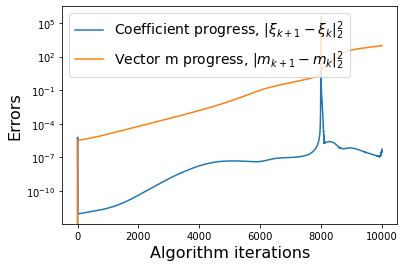

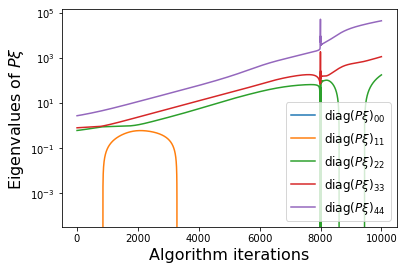

In [142]:
make_progress_plots(r, sindy_opt)

In [ ]:
from matplotlib import animation

# Define the full u(x, y, t) fields for the DNS, POD-Galerkin reconstruction
# and trapping SINDy reconstruction. 
u_true = np.zeros((vort.shape[0], a.shape[0]))
u_galerkin = np.zeros((vort.shape[0], a_galerkin9.shape[0]))
u_energy = np.zeros((vort.shape[0], a.shape[0]))
u_enstrophy = np.zeros((vort.shape[0], a.shape[0]))
n = 128478
r = 5
Psi = np.zeros([n, r])
Psi0 = get_vorticity(mode_path + filename(1))
for i in range(r - 1):
    Psi[:, i] = get_vorticity(mode_path + filename(i + 2))

Psi[:, -1] = get_vorticity(mode_path + filename(10))
    
# for reconstruction with the shift-mode
Psi0 = get_vorticity(mode_path + filename(1))
Psi_mean = np.outer(Psi0, np.ones(x_test.shape[0]))
u_true = Psi_mean + Psi @ x_test.T
u_energy = Psi_mean + Psi @ xtraj_energy.T
u_enstrophy = Psi_mean + Psi @ xtraj_enstrophy.T
Psi_mean = np.outer(Psi0, np.ones(a_galerkin5.shape[0]))
u_galerkin = Psi_mean + Psi @ a_galerkin5.T

# make the animation
fps = 30
fig = plt.figure(1, figsize=(16, 8) )
# plot DNS 
clim = [-3, 3]
tbegin = 400
tend = 2500
plt.subplot(2, 2, 1)
im1 = plot_field(np.reshape(interp(u_true[:, tbegin]), [nx, ny], order='F').T, 
                 clim=clim, label='DNS')
plt.xlim([-1, 9])
plt.ylim([-2, 2])
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
#ax.set_title('t = {0:.2f}'.format(t[tbegin]))
plt.xlabel('DNS', fontsize=18)
# plot POD-Galerkin reconstruction
plt.subplot(2, 2, 2)
im2 = plot_field(np.reshape(interp(u_galerkin[:, tbegin]), [nx, ny], order='F').T, 
                 clim=clim, label='POD-9')
plt.xlim([-1, 9])
plt.ylim([-2, 2])
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.xlabel('POD-5', fontsize=18)
# plot trapping SINDy reconstruction
plt.subplot(2, 2, 3)
im3 = plot_field(np.reshape(interp(u_energy[:, tbegin]), [nx, ny], order='F').T, 
                 clim=clim, label='Trapping SINDy (energy)')
plt.xlim([-1, 9])
plt.ylim([-2, 2])
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.xlabel('Trapping SINDy (energy)', fontsize=18)
plt.subplot(2, 2, 4)
im4 = plot_field(np.reshape(interp(u_enstrophy[:, tbegin]), [nx, ny], order='F').T, 
                 clim=clim, label='Trapping SINDy (enstrophy)')
plt.xlim([-1, 9])
plt.ylim([-2, 2])
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.xlabel('Trapping SINDy (enstrophy)', fontsize=18)
# switch back to subplot 1 
# plt.subplot(2, 2, 1)
# ax = plt.gca()


# animation function for looping through frames
def animate_func(i):
    if i % 100:
        print(i)
    plt.suptitle('t = {0:.2f}'.format(t[i]), fontsize=18)
    im1.set_array(np.reshape(interp(u_true[:, i]), [nx, ny], order='F').T)
    im2.set_array(np.reshape(interp(u_galerkin[:, i]), [nx, ny], order='F').T)
    im3.set_array(np.reshape(interp(u_energy[:, i]), [nx, ny], order='F').T)
    im4.set_array(np.reshape(interp(u_enstrophy[:, i]), [nx, ny], order='F').T)
    return [im1, im2, im3]


# anim = animation.FuncAnimation(fig, 
#                                animate_func, 
#                                frames = np.arange(tbegin, tend, 2),
#                                interval = 200)
# anim.save('vonKarman_meanfield.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])